In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import random
import cv2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

In [ ]:
#Set up collab
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
dir_images='/content/drive/MyDrive/datasets/training/images/'
dir_mask  ='/content/drive/MyDrive/datasets/training/1st_manual/'

# Define augmentation Functions

In [ ]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1])/2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    return result

def bruit(image):
    h, w, c = image.shape
    n = np.random.randn(h, w, c)*random.randint(5, 30)
    return np.clip(image+n, 0, 255).astype(np.uint8)

def change_gamma(image, alpha=1.0, beta=0.0):
    return np.clip(alpha*image+beta, 0, 255).astype(np.uint8)

def color(image, alpha=20):
    n = [random.randint(-alpha, alpha), random.randint(-alpha, alpha),random.randint(-alpha, alpha)]
    return np.clip(image+n, 0, 255).astype(np.uint8)

#randomly apply augmentation
def random_change(image):
    if np.random.randint(2):
        img = change_gamma(image, random.uniform(0.8, 1.2), np.random.randint(100)-50)
    if np.random.randint(2):
        img = bruit(image)
    if np.random.randint(2):
        img = color(image)
    return image

# Apply augmentation

In [ ]:
tab_images = []
tab_masks = []

list_file = os.listdir(dir_images)
if list_file is None:
    quit("No file in {} !".format(dir_images))
    
for fichier in list_file:
    img_orig = cv2.imread(dir_images+fichier)
    
    tab_images.append(img_orig[:576, :560])
    num = fichier.split('_')[0]
    file_mask = dir_mask+num+'_manual1.gif'
    if not os.path.isfile(file_mask):
        quit("Mask of {} doesn't exist in {}".format(file_mask, dir_mask))
    img_mask_orig = np.array(Image.open(file_mask))
    tab_masks.append(img_mask_orig[:576, :560])

    #rotate image by 30° step until reaching 360° 
    #apply random augmentation at each step for different flip
    for angle in range(0, 360, 30):
        img_r = rotateImage(img_orig, angle)
        img = img_r.copy()
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_mask = rotateImage(img_mask_orig, angle)
        tab_masks.append(img_mask[:576, :560])
        
        #flip around x-axes
        img = cv2.flip(img_r, 0)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, 0)
        tab_masks.append(img_m[:576, :560])

        #flip around y-axes
        img = cv2.flip(img_r, 1)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, 1)
        tab_masks.append(img_m[:576, :560])

        #flip around x and y axes
        img = cv2.flip(img_r, -1)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, -1)
        tab_masks.append(img_m[:576, :560])

In [ ]:
tab_images = np.array(tab_images, dtype=np.float32)/255
tab_masks  = np.array(tab_masks,  dtype=np.float32)[:, :, :]/255
train_images, test_images, train_masks, test_masks = train_test_split(tab_images, tab_masks, test_size=0.05)

#del some data to reduce the load on our poor infrastructure
del tab_images
del tab_masks

# Define Unet

In [ ]:
def model(nbr):
    inputs = Input(shape=(576, 560, 3), dtype='float32')

    x = Conv2D(nbr, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(nbr, 3, activation='relu', padding='same')(x)
    x1 = BatchNormalization()(x)

    x = MaxPool2D()(x1)

    x = Conv2D(2*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2*nbr, 3, activation='relu', padding='same')(x)
    x2 = BatchNormalization()(x)

    x = MaxPool2D()(x2)

    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x3 = BatchNormalization()(x)

    x = MaxPool2D()(x3)

    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x4 = BatchNormalization()(x)

    x = MaxPool2D()(x4)

    x = Conv2D(8*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = tf.concat([x, x4], axis=3)

    x = Conv2D(8*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = tf.concat([x, x3], axis=3)
    
    x = Conv2D(4*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = tf.concat([x, x2], axis=3)
    
    x = Conv2D(2*nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D()(x)
    x = tf.concat([x, x1], axis=3)
    
    x = Conv2D(nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(nbr, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    output = Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=entree, outputs=output)
    return model

In [ ]:
def dice_coeff(y_true, y_pred):
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

#Combine dice loss with binary crossentropy loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
metrics = [
        dice_coeff,
        #Jaccard,
        #bce_dice_loss,
        Recall(),
        Precision(),
        AUC()
    ]

In [ ]:
   callbacks = [
        ModelCheckpoint('/content/drive/MyDrive/datasets/unet.h5', verbose=1,
                        save_best_only=True, save_weights_only=True, monitor='val_auc', mode='max'),
        #Reduce learning rate when a metric has stopped improving
        ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3)
    ]

In [ ]:
my_model = model(64)

my_model.compile(optimizer = Adam(lr = 1e-3),
                  loss = bce_dice_loss, 
                  metrics = metrics)

In [ ]:
my_model.fit(train_images,
             train_masks,
             epochs=30,
             batch_size=4,
             validation_data=(test_images, test_masks),
             callbacks=callbacks)

Epoch 1/30
311/311 [==============================] - 304s 817ms/step - loss: 0.9225 - dice_coeff: 0.4490 - recall: 0.6763 - precision: 0.5142 - auc: 0.8597 - val_loss: 1.4678 - val_dice_coeff: 0.0240 - val_recall: 0.0024 - val_precision: 0.2623 - val_auc: 0.5994

Epoch 00001: val_auc improved from -inf to 0.59939, saving model to /content/drive/MyDrive/datasets/unet.h5
Epoch 2/30
311/311 [==============================] - 246s 790ms/step - loss: 0.3772 - dice_coeff: 0.7428 - recall: 0.6687 - precision: 0.9027 - auc: 0.9613 - val_loss: 0.4653 - val_dice_coeff: 0.6967 - val_recall: 0.5078 - val_precision: 0.9516 - val_auc: 0.8979

Epoch 00002: val_auc improved from 0.59939 to 0.89794, saving model to /content/drive/MyDrive/datasets/unet.h5
Epoch 3/30
311/311 [==============================] - 246s 790ms/step - loss: 0.3501 - dice_coeff: 0.7609 - recall: 0.6797 - precision: 0.9141 - auc: 0.9616 - val_loss: 0.3752 - val_dice_coeff: 0.7598 - val_recall: 0.6577 - val_precision: 0.9068 - val

In [ ]:
my_model.load_weights('/content/drive/MyDrive/datasets/unet.h5')

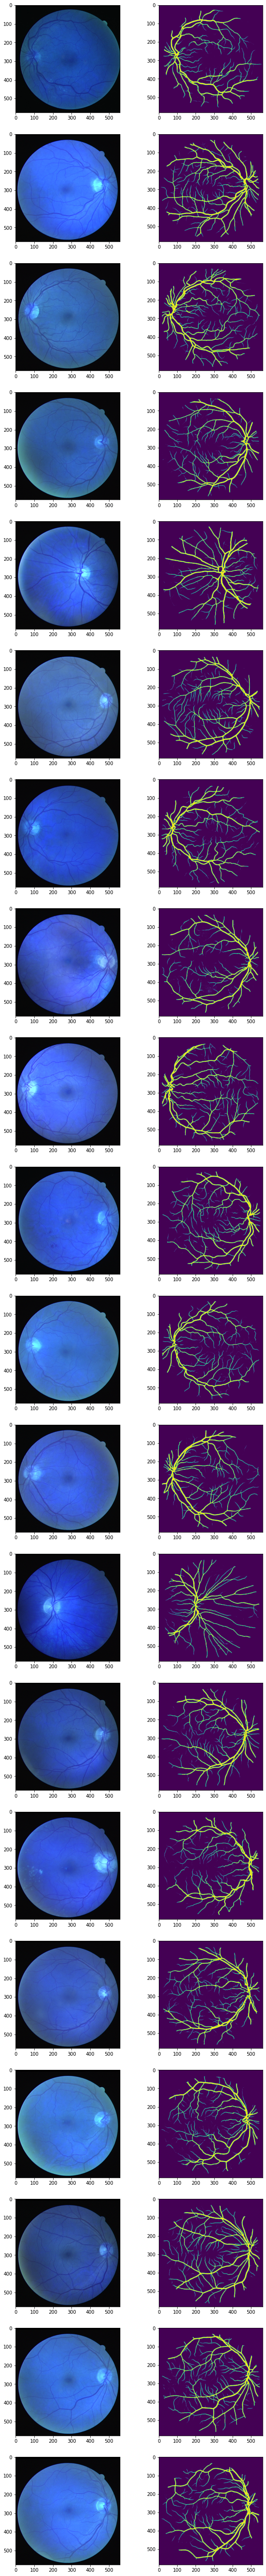

In [ ]:
dir_test_images='/content/drive/MyDrive/datasets/test/images/'

fig, ax = plt.subplots(20,2,figsize=(10,100))
dir_test_images='/content/drive/MyDrive/datasets/test/images/'

tab_test_images=[]
tab_files=[]
for fichier in os.listdir(dir_test_images):
    img=cv2.imread(dir_test_images+fichier)
    tab_test_images.append(img[:576, :560])
    tab_files.append(fichier.split('_')[0])

tab_test_images=np.array(tab_test_images, dtype=np.float32)/255
tab_files=np.array(tab_files)


for id in range(len(tab_test_images)):
    mask=np.zeros((584, 565, 1), dtype=np.float32)
    prediction=my_model.predict(np.array([tab_test_images[id]]))
    mask[:576, :560]=prediction[0]*255
    mask = np.squeeze(mask)

    ax[id, 0].imshow(tab_test_images[id])
    ax[id, 1].imshow(mask)

    cv2.imwrite("/content/drive/MyDrive/datasets/Unet_pred/"+str(tab_files[id])+".png", mask)

fig.show()

Test on the STARE dataset
https://cecas.clemson.edu/~ahoover/stare/probing/index.html

In [ ]:
dir_images = '/content/drive/MyDrive/STARE/images/'
dir_mask = '/content/drive/MyDrive/STARE/label/'

tab_images=[]
tab_masks=[]

list_file=os.listdir(dir_images)
if list_file is None:
    quit("No file in {} !".format(dir_images))
    
for fichier in list_file:
    img_orig=cv2.imread(dir_images+fichier)
    
    tab_images.append(img_orig[:576, :560])
    num=fichier.split('.')[0]
    file_mask=dir_mask+num +'.ah.ppm'
    if not os.path.isfile(file_mask):
        quit("Mask of {} doesn't exist in {}".format(file_mask, dir_mask))
    img_mask_orig=np.array(Image.open(file_mask))
    tab_masks.append(img_mask_orig[:576, :560])

tab_images=np.array(tab_images, dtype=np.float32)/255
tab_masks =np.array(tab_masks,  dtype=np.float32)[:, :, :]/255
_ = my_model.evaluate(tab_images, tab_masks, verbose = 2, batch_size = 3)

7/7 - 2s - loss: 0.4383 - dice_coeff: 0.6716 - recall: 0.7799 - precision: 0.7468 - auc: 0.9608
